In [2]:
path = ".imgs/"

In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter 
import pandas as pd 
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

print(os.listdir(path))


['images.csv', 'images_original', 'images_compressed']


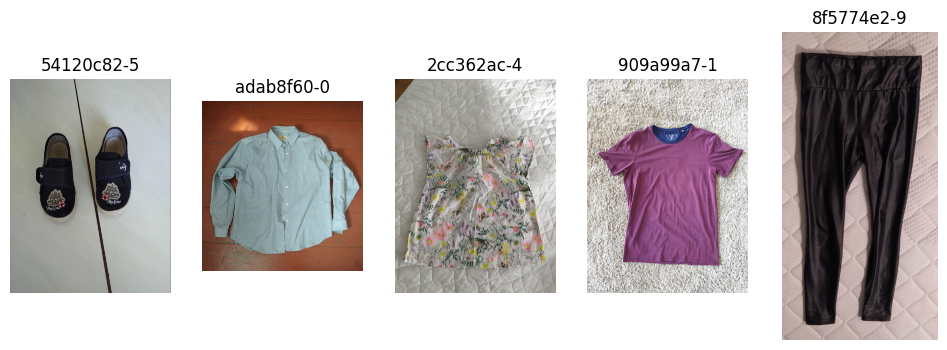

In [4]:

images_path = os.path.join(path, "images_original", "train")
if not os.path.exists(images_path):
    if os.path.exists(os.path.join(path, "images_original", "train")):
        images_path = os.path.join(path, "images_original", "train")
    elif os.path.exists(os.path.join(path, "images_original")):
        images_path = os.path.join(path, "images_original")
    elif os.path.exists(os.path.join(path, "train")):
        images_path = os.path.join(path, "train")
    elif os.path.isdir(path):
        images_path = path
    else:
        raise FileNotFoundError(f"No se encontró la carpeta de imágenes bajo path={path}")

image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))][:5]
if not image_files:
    raise FileNotFoundError(f"No se encontraron imágenes en {images_path}")

n = len(image_files)
plt.figure(figsize=(12, 4))

for i, img_name in enumerate(image_files):
    img_path = os.path.join(images_path, img_name)
    img = Image.open(img_path)

    plt.subplot(1, n, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_name[:10])

plt.show()


In [5]:
df = pd.read_csv(os.path.join(path, "images.csv"))
print(df.head())

                                  image  sender_id     label   kids
0  4285fab0-751a-4b74-8e9b-43af05deee22        124  Not sure  False
1  ea7b6656-3f84-4eb3-9099-23e623fc1018        148   T-Shirt  False
2  00627a3f-0477-401c-95eb-92642cbe078d         94  Not sure  False
3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43   T-Shirt  False
4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189     Shoes  False


In [6]:
IMAGE_PATH = ".imgs/images_original/"
IMG_SIZE = 64  

VALID_LABELS = ['T-Shirt', 'Longsleeve', 'Pants', 'Shoes']

X = []
y = []

# Filtramos solo las clases deseadas
df_filtered = df[df['label'].isin(VALID_LABELS)]

for _, row in df_filtered.iterrows():
    img_file = os.path.join(IMAGE_PATH, row['image'] + ".jpg")
    
    img = cv2.imread(img_file)
    if img is None:
        continue
    
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0              # Normalización
    img = img.flatten()            # 64x64x3 → 12288
    
    X.append(img)
    y.append(row['label'])
X = np.array(X)
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
print(le.classes_)

# Dividimos los datos (usa stratify para mantener el balance de clases)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 1. Escalado (Crucial para SVM y PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

['Longsleeve' 'Pants' 'Shoes' 'T-Shirt']


In [8]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
svm = SVC(
    kernel='rbf',
    C=10, 
    gamma='scale',
    class_weight='balanced', 
    probability=True
)

svm.fit(X_train_pca, y_train)

,C,10
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [ ]:
y_pred = svm.predict(X_test_pca)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.8253968253968254
              precision    recall  f1-score   support

  Longsleeve       0.73      0.87      0.79       140
       Pants       0.91      0.83      0.87       139
       Shoes       0.77      0.71      0.74        86
     T-Shirt       0.88      0.84      0.86       202

    accuracy                           0.83       567
   macro avg       0.82      0.81      0.81       567
weighted avg       0.83      0.83      0.83       567



**PREDICCIONES**

In [11]:
img = imread(".imgs/images_compressed/0a30baec-1938-47c5-b495-68a51701b43d.jpg")
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img / 255.0
img = img.flatten().reshape(1, -1)

# mismo scaler
img_scaled = scaler.transform(img)

# mismo PCA
img_pca = pca.transform(img_scaled)

# predicción
pred = svm.predict(img_pca)

print("Clase predicha:", le.classes_[pred[0]-1])


print("Clase predicha:", pred[0])

Clase predicha: Pants
Clase predicha: 2


In [12]:
img = imread("blazer.jpg")
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img = img / 255.0
img = img.flatten().reshape(1, -1)

# mismo scaler
img_scaled = scaler.transform(img)

# mismo PCA
img_pca = pca.transform(img_scaled)

# predicción
pred = svm.predict(img_pca)

print("Clase predicha:", le.classes_[pred[0]-1])


print("Clase predicha:", le.classes_[pred[0]-1])

Clase predicha: Shoes
Clase predicha: Shoes


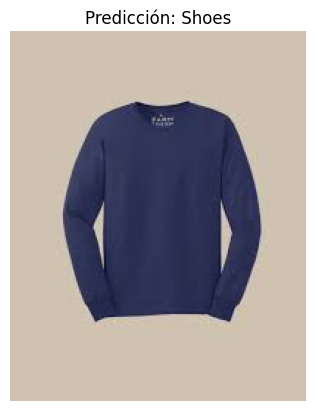

In [13]:
import matplotlib.pyplot as plt

img_show = cv2.cvtColor(
    cv2.imread("Longsleeve.jpeg"),
    cv2.COLOR_BGR2RGB
)

plt.imshow(img_show)
plt.title(f"Predicción: {le.classes_[pred[0]-1]}")
plt.axis("off")
plt.show()


In [14]:
# --- Celda de Predicción corregida ---
def predecir_prenda(ruta_imagen):
    # 1. Cargar y redimensionar igual que en el entrenamiento
    img = cv2.imread(ruta_imagen)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.flatten().reshape(1, -1) # Convertir a una sola fila
    
    # 2. Aplicar los MISMOS pasos de transformación
    img_scaled = scaler.transform(img)      # Primero escalar
    img_pca = pca.transform(img_scaled)     # Luego PCA
    
    # 3. Predicción
    pred_idx = svm.predict(img_pca)[0]
    confianza = np.max(svm.predict_proba(img_pca)) * 100
    
    clase = le.classes_[pred_idx]
    print(f"Predicción: {clase} ({confianza:.2f}% de confianza)")
    return clase

# Ejemplo de uso:
predecir_prenda("camiseta.png")

Predicción: T-Shirt (42.33% de confianza)


np.str_('T-Shirt')

In [15]:
predecir_prenda("shoes.png")

[ WARN:0@104.075] global loadsave.cpp:275 findDecoder imread_('shoes.png'): can't open/read file: check file path/integrity


error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


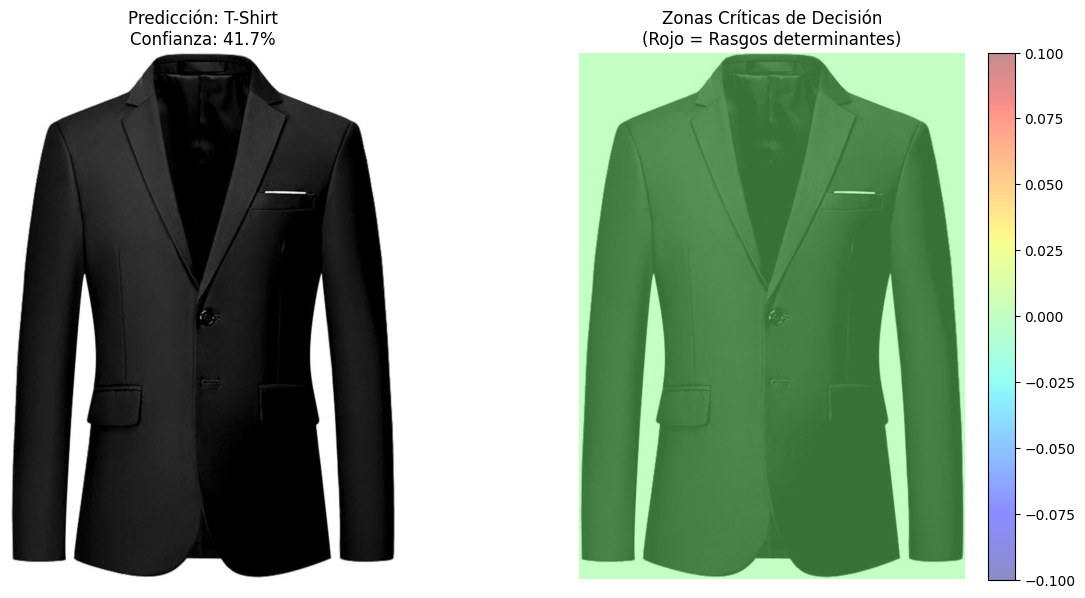

In [ ]:
def visualizar_zonas_importancia(ruta_img, tamaño_bloque=4):
    # 1. Cargar y preparar imágenes
    img_orig = cv2.imread(ruta_img)
    if img_orig is None:
        print(f"No se encontró la imagen en: {ruta_img}")
        return
    
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    # IMG_SIZE debe coincidir con el que usaste en el entrenamiento (ej. 64)
    IMG_SIZE = 64 
    img_res = cv2.resize(img_orig, (IMG_SIZE, IMG_SIZE))
    
    # Preproceso inicial
    img_flat = img_res.flatten().reshape(1, -1)
    img_scaled = scaler.transform(img_flat)
    img_pca = pca.transform(img_scaled)
    
    # Probabilidad original
    probs_base = svm.predict_proba(img_pca)[0]
    clase_idx = np.argmax(probs_base)
    prob_base = probs_base[clase_idx]
    
    # 2. Generar Mapa de Oclusión
    heatmap = np.zeros((IMG_SIZE, IMG_SIZE))
    
    for y in range(0, IMG_SIZE, tamaño_bloque):
        for x in range(0, IMG_SIZE, tamaño_bloque):
            img_ocluida = img_res.copy()
            # Usamos un gris neutro (127) en lugar de negro para no alterar tanto la media
            img_ocluida[y:y+tamaño_bloque, x:x+tamaño_bloque] = 127 
            
            img_o_flat = img_ocluida.flatten().reshape(1, -1)
            img_o_scaled = scaler.transform(img_o_flat)
            img_o_pca = pca.transform(img_o_scaled)
            
            prob_nueva = svm.predict_proba(img_o_pca)[0][clase_idx]
            
            # Calculamos la caída de confianza
            importancia = max(0, prob_base - prob_nueva)
            heatmap[y:y+tamaño_bloque, x:x+tamaño_bloque] = importancia

    # --- MEJORAS ESTÉTICAS ---
    
    # A. Normalizar el heatmap (0 a 1) para que los colores resalten
    if heatmap.max() > 0:
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    # B. Suavizado Gaussiano (hace que parezca una nube de importancia)
    heatmap_smooth = gaussian_filter(heatmap, sigma=1.5)
    
    # C. Escalar el heatmap al tamaño de la imagen original para que el overlay sea perfecto
    heatmap_resized = cv2.resize(heatmap_smooth, (img_rgb.shape[1], img_rgb.shape[0]))

    # 3. Mostrar resultados
    plt.figure(figsize=(12, 6))
    
    # Imagen Original
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title(f"Predicción: {le.classes_[clase_idx]}\nConfianza: {prob_base*100:.1f}%", fontsize=12)
    plt.axis('off')
    
    # Imagen con Heatmap resaltado
    plt.subplot(1, 2, 2)
    plt.imshow(img_rgb)
    # Usamos el mapa 'jet' o 'hot' para el resalte
    overlay = plt.imshow(heatmap_resized, cmap='jet', alpha=0.45) 
    plt.title("Zonas Críticas de Decisión\n(Rojo = Rasgos determinantes)", fontsize=12)
    plt.axis('off')
    
    # Barra de color para referencia
    plt.colorbar(overlay, ax=plt.gca(), fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Ejecutar con tu imagen
visualizar_zonas_importancia("blazer.jpg")

Generando reporte visual de desempeño...


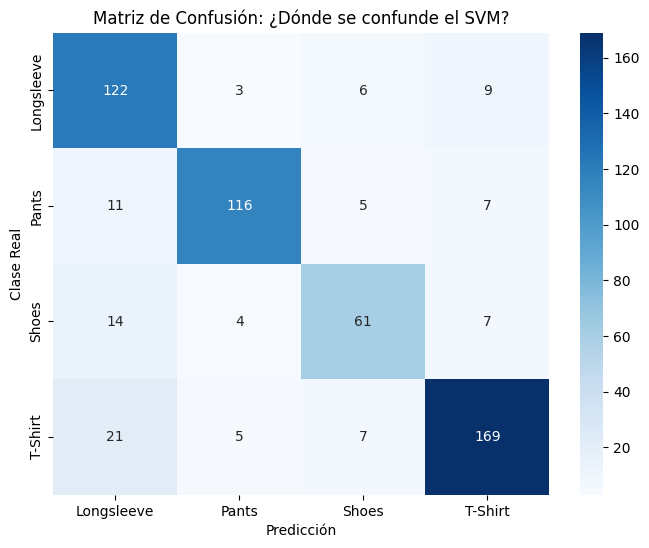

Analizando componentes principales...


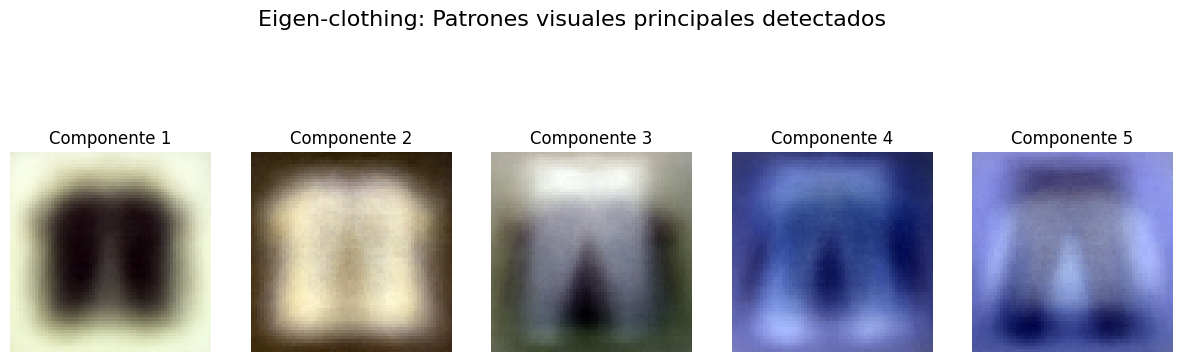

Generando mapa de importancia para imagen específica...


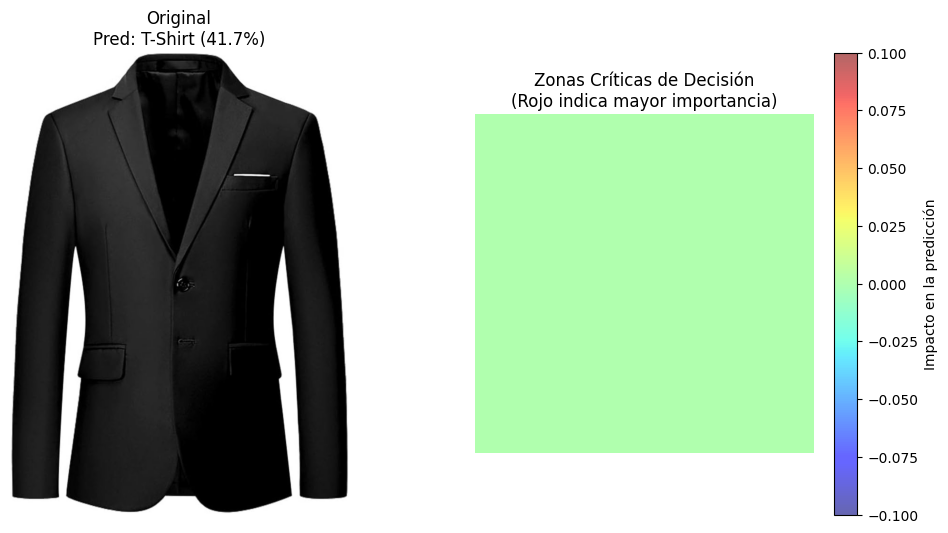

In [ ]:
# 1. VISUALIZACIÓN DE LA MATRIZ DE CONFUSIÓN (Indispensable para el reporte)
def graficar_matriz_confusion(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusión: ¿Dónde se confunde el SVM?')
    plt.ylabel('Clase Real')
    plt.xlabel('Predicción')
    plt.show()

# 2. VISUALIZACIÓN DE EIGEN-CLOTHES (¿Qué "ve" el PCA antes del SVM?)
def visualizar_componentes_pca(pca, img_size=(64, 64)):
    # Los componentes de PCA son las "bases" que el modelo usa para entender la ropa
    n_comp = 5 # Vamos a ver los primeros 5
    plt.figure(figsize=(15, 5))
    for i in range(n_comp):
        plt.subplot(1, n_comp, i + 1)
        # Reshape del componente a la forma de la imagen (asumiendo 3 canales)
        # Nota: Si usaste color, es 64x64x3. Si es escala de grises, 64x64.
        comp_img = pca.components_[i].reshape(img_size[0], img_size[1], 3)
        # Normalizamos para visualización
        comp_img = (comp_img - comp_img.min()) / (comp_img.max() - comp_img.min())
        plt.imshow(comp_img)
        plt.title(f'Componente {i+1}')
        plt.axis('off')
    plt.suptitle("Eigen-clothing: Patrones visuales principales detectados", fontsize=16)
    plt.show()

# 3. MEJORA DE LA FUNCIÓN DE MAPA DE CALOR (OCLUSIÓN)
def explicar_prediccion_svm(ruta_img, svm_model, pca_transformer, scaler_model, le_classes, img_size=64):
    """
    Genera un heatmap detallado mostrando qué partes de la imagen 
    influyen más en la decisión del SVM.
    """
    # Carga y preproceso
    img_orig = cv2.imread(ruta_img)
    if img_orig is None: 
        print("Error: No se encontró la imagen.")
        return
    
    img_rgb = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_res = cv2.resize(img_orig, (img_size, img_size))
    
    # Probabilidad base
    img_input = img_res.flatten().reshape(1, -1)
    img_input = scaler_model.transform(img_input)
    img_input_pca = pca_transformer.transform(img_input)
    
    probs_base = svm_model.predict_proba(img_input_pca)[0]
    clase_idx = np.argmax(probs_base)
    prob_base = probs_base[clase_idx]
    
    # Crear Heatmap por oclusión
    # Usamos un tamaño de bloque pequeño para más detalle
    block_size = 4 
    heatmap = np.zeros((img_size, img_size))
    
    for y in range(0, img_size, block_size):
        for x in range(0, img_size, block_size):
            img_occ = img_res.copy()
            # Ocluimos con un color neutro (gris medio) para no sesgar tanto como el negro puro
            img_occ[y:y+block_size, x:x+block_size] = 127 
            
            img_occ_input = img_occ.flatten().reshape(1, -1)
            img_occ_input = scaler_model.transform(img_occ_input)
            img_occ_pca = pca_transformer.transform(img_occ_input)
            
            prob_occ = svm_model.predict_proba(img_occ_pca)[0][clase_idx]
            
            # Si la probabilidad baja mucho al tapar esa zona, es que esa zona es IMPORTANTE
            heatmap[y:y+block_size, x:x+block_size] = prob_base - prob_occ

    # Visualización
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(img_rgb)
    ax[0].set_title(f"Original\nPred: {le_classes[clase_idx]} ({prob_base*100:.1f}%)")
    ax[0].axis('off')
    
    # Heatmap suavizado
    import scipy.ndimage as ndimage
    heatmap_smooth = ndimage.gaussian_filter(heatmap, sigma=1)
    
    im = ax[1].imshow(img_rgb)
    ax[1].imshow(heatmap_smooth, cmap='jet', alpha=0.6)
    ax[1].set_title("Zonas Críticas de Decisión\n(Rojo indica mayor importancia)")
    ax[1].axis('off')
    
    plt.colorbar(ax[1].images[1], ax=ax[1], label='Impacto en la predicción')
    plt.show()

# ==============================================================================
# EJECUCIÓN DE LAS PRUEBAS
# ==============================================================================

# 1. Graficar Matriz de Confusión con los resultados del test
print("Generando reporte visual de desempeño...")
graficar_matriz_confusion(y_test, y_pred, le.classes_)

# 2. Ver que está viendo el PCA
print("Analizando componentes principales...")
visualizar_componentes_pca(pca)

# 3. Explicar una imagen específica (cambia la ruta por una que tengas)
# Nota: corregí el error de pred[0]-1 de tus celdas anteriores, usa el índice directo
print("Generando mapa de importancia para imagen específica...")
explicar_prediccion_svm("blazer.jpg", svm, pca, scaler, le.classes_)

In [17]:
def get_gradients(image, target_class):
        """
        Calcula los gradientes numéricos respecto a la imagen de entrada.
        """
        epsilon = 1e-2
        grads = np.zeros_like(image)
        
        for i in range(image.shape[0]):
            # Perturbación positiva
            image_plus = image.copy()
            image_plus[i] += epsilon
            
            # Perturbación negativa
            image_minus = image.copy()
            image_minus[i] -= epsilon
            
            # Procesar ambas versiones
            plus_scaled = scaler.transform(image_plus.reshape(1, -1))
            plus_pca = pca.transform(plus_scaled)
            prob_plus = svm.predict_proba(plus_pca)[0, target_class]
            
            minus_scaled = scaler.transform(image_minus.reshape(1, -1))
            minus_pca = pca.transform(minus_scaled)
            prob_minus = svm.predict_proba(minus_pca)[0, target_class]
            
            # Gradiente numé    rico
            grads[i] = (prob_plus - prob_minus) / (2 * epsilon)
        
        return grads

In [ ]:
def integrated_gradients(image, baseline=None, target_class=None, 
                            num_steps=50):
        """
        Calcula los Gradientes Integrados.
        
        Args:
            image: Imagen de entrada (flatten)
            baseline: Imagen base (por defecto: imagen negra)
            target_class: Clase objetivo (por defecto: clase predicha)
            num_steps: Número de pasos de integración
        """
        if baseline is None:
            baseline = np.zeros_like(image)
        
        # Predecir clase si no se especifica
        if target_class is None:
            img_scaled = scaler.transform(image.reshape(1, -1))
            img_pca = pca.transform(img_scaled)
            target_class = svm.predict(img_pca)[0]
        
        # Interpolar entre baseline e imagen
        alphas = np.linspace(0, 1, num_steps)
        integrated_grads = np.zeros_like(image)
        
        for alpha in alphas:
            interpolated = baseline + alpha * (image - baseline)
            grads = get_gradients(interpolated, target_class)
            integrated_grads += grads
        
        # Promedio y multiplicar por diferencia
        integrated_grads = integrated_grads / num_steps
        integrated_grads = (image - baseline) * integrated_grads
        
        return integrated_grads, target_class
    

In [ ]:
def visualize_attribution(image_path, fig_size=(15, 5)):
        """
        Visualiza la imagen original y su mapa de atribución.
        """
        # Cargar y procesar imagen
        img_original = cv2.imread(image_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_original, (IMG_SIZE, IMG_SIZE))
        img_normalized = img_resized / 255.0
        img_flat = img_normalized.flatten()
        
        # Calcular gradientes integrados
        attributions, pred_class = integrated_gradients(img_flat)
        
        # Redimensionar atribuciones a forma de imagen
        attr_reshaped = attributions.reshape(IMG_SIZE, IMG_SIZE, 3)
        
        # Obtener probabilidades
        img_scaled = scaler.transform(img_flat.reshape(1, -1))
        img_pca = pca.transform(img_scaled)
        probs = svm.predict_proba(img_pca)[0]
        
        # Visualización
        fig, axes = plt.subplots(1, 3, figsize=fig_size)
        
        # Imagen original
        axes[0].imshow(img_resized / 255.0)
        axes[0].set_title('Imagen Original')
        axes[0].axis('off')
        
        # Mapa de calor de atribuciones (suma de canales RGB)
        attr_magnitude = np.sum(np.abs(attr_reshaped), axis=2)
        im = axes[1].imshow(attr_magnitude, cmap='hot')
        axes[1].set_title('Mapa de Importancia\n(Gradientes Integrados)')
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1], fraction=0.046)
        
        # Superposición
        attr_normalized = (attr_magnitude - attr_magnitude.min()) / \
                         (attr_magnitude.max() - attr_magnitude.min() + 1e-8)
        overlay = img_resized / 255.0 * 0.5 + \
                 plt.cm.hot(attr_normalized)[:, :, :3] * 0.5
        axes[2].imshow(overlay)
        axes[2].set_title('Superposición')
        axes[2].axis('off')
        
        clase_pred = le.classes_[pred_class]
        confianza = probs[pred_class] * 100
        fig.suptitle(f'Predicción: {clase_pred} ({confianza:.1f}% confianza)', 
                    fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        for i, clase in enumerate(le.classes_):
            print(f"  {clase}: {probs[i]*100:.2f}%")
        
        return attributions, pred_class

In [ ]:


# Función para comparar múltiples imágenes
def comparar_predicciones(rutas_imagenes):
    """
    Compara las explicaciones de múltiples imágenes.
    """
    n_imgs = len(rutas_imagenes)
    fig, axes = plt.subplots(n_imgs, 3, figsize=(15, 5*n_imgs))
    
    if n_imgs == 1:
        axes = axes.reshape(1, -1)
    
    for idx, ruta in enumerate(rutas_imagenes):
        # Cargar imagen
        img_original = cv2.imread(ruta)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_original, (IMG_SIZE, IMG_SIZE))
        img_flat = (img_resized / 255.0).flatten()
        
        # Calcular atribuciones
        attributions, pred_class = integrated_gradients(img_flat)
        attr_reshaped = attributions.reshape(IMG_SIZE, IMG_SIZE, 3)
        attr_magnitude = np.sum(np.abs(attr_reshaped), axis=2)
        
        # Obtener probabilidad
        img_scaled = scaler.transform(img_flat.reshape(1, -1))
        img_pca = pca.transform(img_scaled)
        prob = np.max(svm.predict_proba(img_pca)) * 100
        
        # Visualizar
        axes[idx, 0].imshow(img_resized / 255.0)
        axes[idx, 0].set_title(f'{ruta}')
        axes[idx, 0].axis('off')
        
        im = axes[idx, 1].imshow(attr_magnitude, cmap='hot')
        axes[idx, 1].set_title('Gradientes Integrados')
        axes[idx, 1].axis('off')
        plt.colorbar(im, ax=axes[idx, 1], fraction=0.046)
        
        attr_norm = (attr_magnitude - attr_magnitude.min()) / \
                    (attr_magnitude.max() - attr_magnitude.min() + 1e-8)
        overlay = img_resized/255.0 * 0.5 + plt.cm.hot(attr_norm)[:,:,:3] * 0.5
        axes[idx, 2].imshow(overlay)
        clase = le.classes_[pred_class]
        axes[idx, 2].set_title(f'Pred: {clase} ({prob:.1f}%)')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Ejemplo de comparación
# comparar_predicciones(["camiseta.png", "shoes.png", "blazer.jpg"])

In [ ]:
comparar_predicciones(["camiseta.png", "shoes.png", "blazer.jpg"])